# 📊 Проверка гипотезы ML-рекомендаций: A/A и A/B тесты CTR  

## 🎯 Цель исследования  
Команда ML разработала новые алгоритмы рекомендаций постов в ленте.  
Основная гипотеза: **новый алгоритм делает рекомендации интереснее для пользователей**,  
что должно выражаться в росте CTR (отношение количества лайков к количеству просмотров).  

Для принятия решения о раскатке алгоритма необходимо:  
1. Проверить корректность системы сплитования с помощью **A/A-теста**.  
2. Проанализировать результаты эксперимента (контрольная vs тестовая группа) с помощью **A/B-теста**.  
3. Сравнить результаты разными статистическими методами и сделать выводы.  

---

## 📝 Задачи ноутбука  

**Задание 1 — A/A-тест**  
- Используем данные за период `2025-07-26 — 2025-08-01`.  
- Берём группы `2` и `3` как идентичные по функциональности.  
- Формируем подвыборки по 500 пользователей, сравниваем их CTR с помощью t-теста.  
- Повторяем процедуру 10 000 раз.  
- Анализируем распределение p-value и проверяем, соответствует ли доля «ложных срабатываний» (p < 0.05) ожидаемому уровню значимости.  

**Задание 2 — A/B-тест**  
- Данные за период `2025-08-02 — 2025-08-08`.  
- Контрольная группа: `1`.  
- Тестовая группа: `2` (новый алгоритм рекомендаций).  
- Сравниваем CTR в группах с помощью разных методов:  
  - t-тест,  
  - Манна-Уитни,  
  - Пуассоновский бутстреп,  
  - t-тест на сглаженном CTR (α=5),  
  - t-тест и Манна-Уитни после бакетизации.  
- Визуально сравниваем распределения метрик.  
- Формулируем гипотезы о причинах полученных результатов.  
- Даём рекомендацию о раскатке нового алгоритма.  

---

## 📂 Описание данных  

Каждая строка датасета — это событие пользователя в ленте.  

**Столбцы:**  
- `user_id` — идентификатор пользователя  
- `post_id` — идентификатор поста  
- `action` — действие (`view` или `like`)  
- `time` — время события  
- `gender` — пол пользователя (0/1)  
- `age` — возраст пользователя  
- `country` — страна  
- `city` — город  
- `os` — операционная система (`iOS`, `Android`)  
- `source` — источник (`ads` или `organic`)  
- `exp_group` — группа эксперимента (контроль/тест/AA)  

📌 Основная метрика анализа: **CTR = число лайков / число просмотров**.  

## 1. Загрузка данных

In [1]:
import pandas as pd
import clickhouse_connect
import swifter
import hashlib
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt

In [2]:
client = clickhouse_connect.get_client(
    host='clickhouse.lab.karpov.courses',  # без https://
    port=443,                              # т.к. https
    username='student',
    password='dpo_python_2020',
    database='simulator',
    secure=True                            # включаем TLS
)

In [3]:
q = """
SELECT * 
FROM simulator_20250820.feed_actions 
LIMIT 1000
"""

In [4]:
# Вытащили пользователей
client.query_df(q).head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,33979,2800,like,2025-08-14 18:55:05+03:00,1,15,Russia,Yoshkar-Ola,iOS,ads,2
1,36220,2813,view,2025-08-14 18:55:05+03:00,1,38,Russia,Kostroma,iOS,ads,4
2,36504,2867,view,2025-08-14 18:55:05+03:00,1,22,Russia,Serov,Android,ads,0
3,37189,2961,like,2025-08-14 18:55:05+03:00,1,23,Russia,Krasnotur’insk,iOS,ads,1
4,38530,2845,view,2025-08-14 18:55:05+03:00,1,18,Ukraine,Zhmerynka,iOS,ads,1


## 3. A/A-тест (проверка корректности сплитования)  

In [5]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250820.feed_actions 
WHERE toDate(time) >= '2025-07-26' and toDate(time) <= '2025-08-01' 
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [6]:
df = client.query_df(q)

In [7]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [8]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


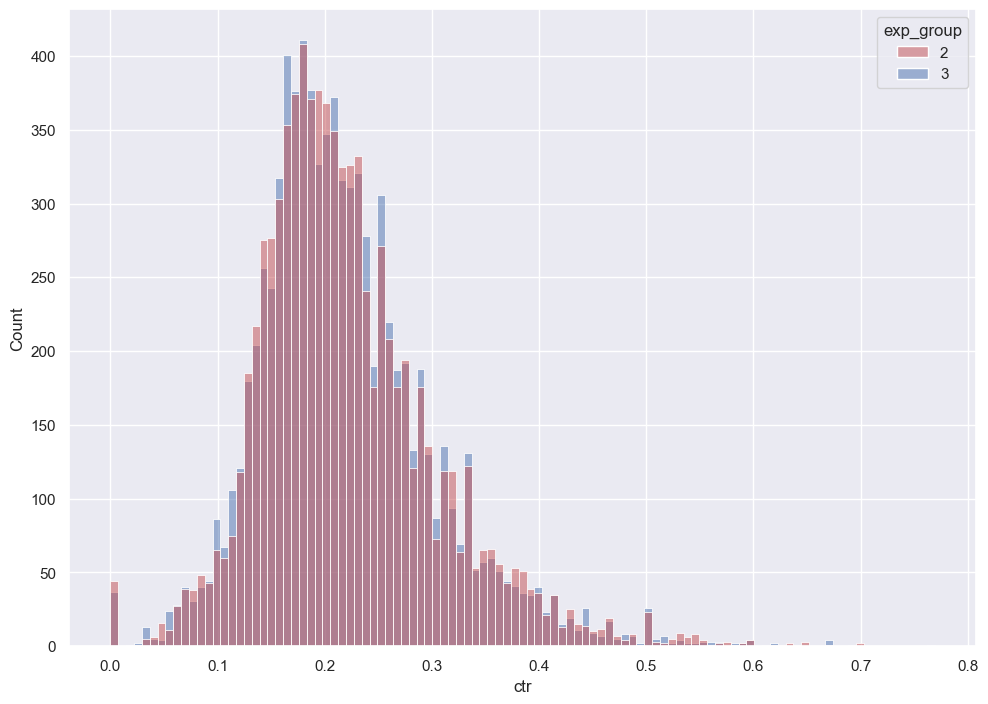

In [9]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [10]:
# 1) Берём CTR по группам 2 и 3; на всякий случай отсечём тех, у кого views == 0
g2 = df[(df['exp_group'] == 2) & (df['views'] > 0)]
g3 = df[(df['exp_group'] == 3) & (df['views'] > 0)]

In [11]:
ctr2 = g2['ctr'].to_numpy(dtype=float)  # 1D массив
ctr3 = g3['ctr'].to_numpy(dtype=float)  # 1D массив

In [12]:
n2 = ctr2.shape[0]
n3 = ctr3.shape[0]

In [13]:
# 2) Размер подвыборок: 500, но если данных меньше — берём сколько есть
S = min(500, n2, n3)
N = 10_000

In [14]:
# 3) Повторы t-теста (без возвращения)
rng = np.random.default_rng(0)  # фиксируем сид для повторяемости
p_values = np.empty(N, dtype=float)

In [15]:
for i in range(N):
    idx2 = np.random.choice(n2, size=S, replace=False)
    idx3 = np.random.choice(n3, size=S, replace=False)
    _, p = ttest_ind(ctr2[idx2], ctr3[idx3], equal_var=False)
    p_values[i] = p

In [16]:
# 4) Короткая сводка
alpha = 0.05
print(f"grp2: n={n2}, grp3: n={n3}, sample size per group={S}, repeats={N}")
print(f"Доля p < {alpha}: {(p_values < alpha).mean()*100:.2f}%")
print(f"Среднее p-value: {p_values.mean():.4f}, медиана: {np.median(p_values):.4f}")

grp2: n=8362, grp3: n=8425, sample size per group=500, repeats=10000
Доля p < 0.05: 4.60%
Среднее p-value: 0.5103, медиана: 0.5171


Доля p < 0.05: 0.0460


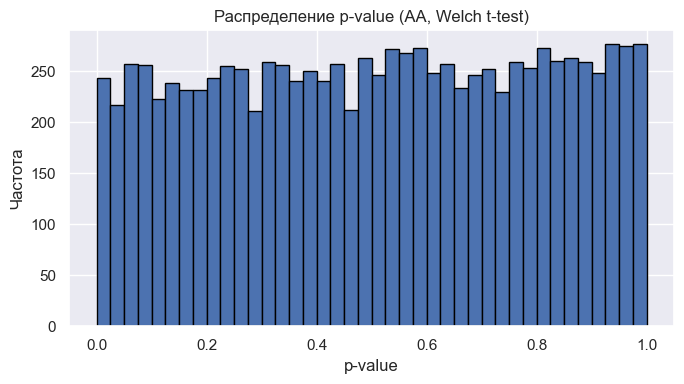

In [17]:
alpha = 0.05
share = (p_values < alpha).mean()

print(f"Доля p < {alpha}: {share:.4f}")

plt.figure(figsize=(7,4))
plt.hist(p_values, bins=40, edgecolor='black')
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.title("Распределение p-value (AA, Welch t-test)")
plt.tight_layout()
plt.show()


## 4. A/B-тест (анализ гипотезы ML-рекомендаций) 

### 4.1 Постановка гипотезы  

### 4.2 Методы анализа  

In [18]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250820.feed_actions 
WHERE toDate(time) >= '2025-08-02' and toDate(time) <= '2025-08-08' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [19]:
df = client.query_df(q)

In [20]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
...,...,...,...,...,...
19892,1,132567,52,326,0.159509
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [21]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [22]:
g1 = df[df.exp_group == 1].copy()
g2 = df[df.exp_group == 2].copy()
print("means:", g1['ctr'].mean(), g2['ctr'].mean())
print("medians:", g1['ctr'].median(), g2['ctr'].median())
print("sizes:", len(g1), len(g2))

means: 0.21677399412007203 0.21610168932378176
medians: 0.20588235294117646 0.15328467153284672
sizes: 10020 9877


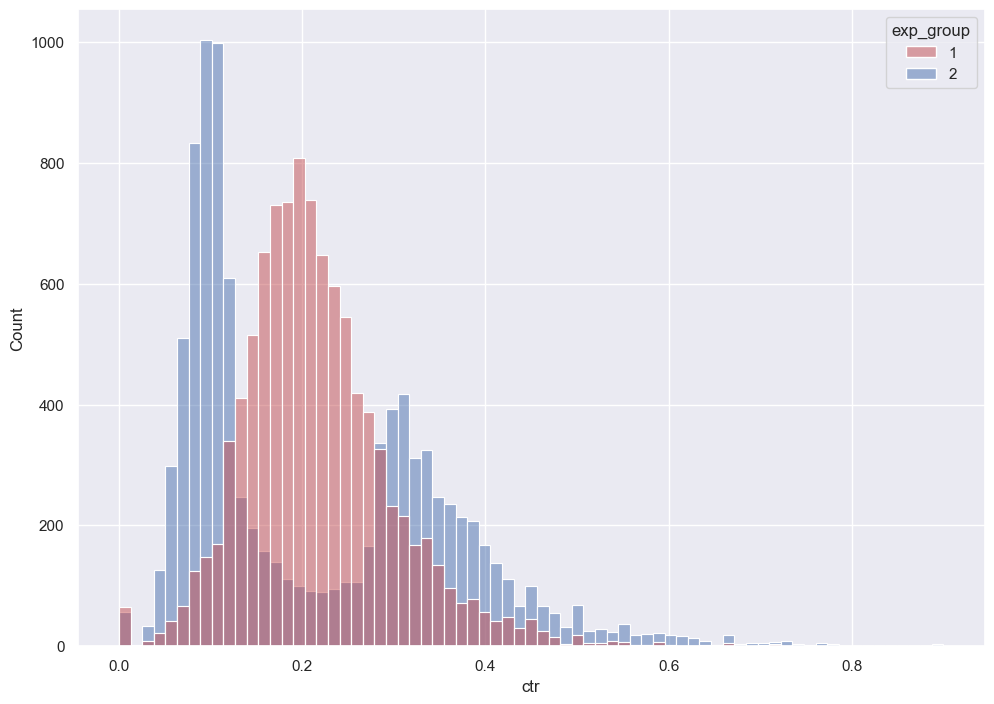

In [23]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [24]:
ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

TtestResult(statistic=np.float64(0.405149191311259), pvalue=np.float64(0.6853733311407633), df=np.float64(15811.226497970863))

In [25]:
mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=np.float64(55189913.0), pvalue=np.float64(4.632205841806026e-45))

In [26]:
alpha = 5.0

In [27]:
g1['ctr_smooth'] = (g1['likes'] + alpha) / (g1['views'] + alpha)
g2['ctr_smooth'] = (g2['likes'] + alpha) / (g2['views'] + alpha)

In [28]:
ttest_ind(g1['ctr_smooth'], g2['ctr_smooth'], equal_var=False)

TtestResult(statistic=np.float64(0.691688497593362), pvalue=np.float64(0.4891423301403801), df=np.float64(17159.564739089637))

In [29]:
rng = np.random.default_rng(0)
R = 5000

In [30]:
def pois_boot_ratio(df):
    w = rng.poisson(1, size=len(df))
    return (w @ df['likes']) / (w @ df['views'])

In [31]:
g1_vals = []
g2_vals = []

In [32]:
for _ in range(R):
    g1_vals.append(pois_boot_ratio(g1))
    g2_vals.append(pois_boot_ratio(g2))

In [33]:
g1_vals = np.array(g1_vals); g2_vals = np.array(g2_vals)
diff = g2_vals - g1_vals  # lift новой группы

In [34]:
# двусторонний p-value как доля репликаций, где знак «противоположен» среднему
p_boot = 2 * min((diff >= 0).mean(), (diff <= 0).mean())
print("Poisson bootstrap p-value:", p_boot, "| mean lift:", diff.mean())

Poisson bootstrap p-value: 0.0 | mean lift: -0.009346183449988834


In [35]:
B = 64

In [36]:
df['bucket'] = (df['user_id'] % B).astype(int)

In [37]:
agg = df.groupby(['exp_group','bucket'], as_index=False).agg({'likes':'sum','views':'sum'})

In [38]:
agg['ctr'] = agg['likes'] / agg['views']

In [39]:
b1 = agg[agg.exp_group==1]['ctr'].to_numpy()

In [40]:
b2 = agg[agg.exp_group==2]['ctr'].to_numpy()

In [41]:
_, p_t_b = ttest_ind(b1, b2, equal_var=False)

In [42]:
_, p_u_b = mannwhitneyu(b1, b2, alternative='two-sided')

In [43]:
print("Bucket t-test p:", p_t_b, "| Bucket MWU p:", p_u_b)

Bucket t-test p: 1.8844954408801668e-08 | Bucket MWU p: 4.075103736835467e-08


In [44]:
# 1) Грузим агрегаты по юзерам для групп 0,1,2,3 в нужном диапазоне A/B
q = """
SELECT
  exp_group,
  user_id,
  sum(action='like') AS likes,
  sum(action='view') AS views
FROM simulator_20250820.feed_actions
WHERE toDate(time) BETWEEN '2025-08-02' AND '2025-08-08'
  AND exp_group IN (0,1,2,3)
GROUP BY exp_group, user_id
"""

In [45]:
df = client.query_df(q)

In [46]:

def lin_test(df, control, test):
    c = df[df.exp_group == control].copy()
    t = df[df.exp_group == test].copy()

    # Контрольный общий CTR (для линеаризации)
    ctr_ctrl = c['likes'].sum() / c['views'].sum()

    # Линеаризованные лайки: likes - CTR_control * views
    c['lin'] = c['likes'] - ctr_ctrl * c['views']
    t['lin'] = t['likes'] - ctr_ctrl * t['views']

    # Welch t-test на линеаризованных лайках
    p_lin = ttest_ind(c['lin'], t['lin'], equal_var=False).pvalue

    # Для сравнения: обычный t-test на per-user CTR (фильтруем views>0)
    c_ctr = (c[c['views'] > 0]['likes'] / c[c['views'] > 0]['views']).to_numpy()
    t_ctr = (t[t['views'] > 0]['likes'] / t[t['views'] > 0]['views']).to_numpy()
    p_ctr = ttest_ind(c_ctr, t_ctr, equal_var=False).pvalue

    # Полезные сводки
    ctr_total_c = c['likes'].sum() / c['views'].sum()
    ctr_total_t = t['likes'].sum() / t['views'].sum()
    lift_total = ctr_total_t - ctr_total_c

    print(f"--- Control={control} vs Test={test} ---")
    print(f"Users: ctrl={len(c)}, test={len(t)}")
    print(f"CTR_control (общий): {ctr_ctrl:.6f}")
    print(f"Event-level CTR: ctrl={ctr_total_c:.6f}, test={ctr_total_t:.6f}, lift={lift_total:+.6f}")
    print(f"Welch t-test on linearized_likes: p={p_lin:.6g}")
    print(f"Welch t-test on per-user CTR    : p={p_ctr:.6g}")
    print("(ожидаем p_lin <= p_ctr при той же направленности эффекта)\n")

# 3) Запуски: 0 vs 3 и 1 vs 2
lin_test(df, control=0, test=3)
lin_test(df, control=1, test=2)

--- Control=0 vs Test=3 ---
Users: ctrl=9920, test=10002
CTR_control (общий): 0.209838
Event-level CTR: ctrl=0.209838, test=0.226207, lift=+0.016369
Welch t-test on linearized_likes: p=1.49181e-58
Welch t-test on per-user CTR    : p=6.21605e-44
(ожидаем p_lin <= p_ctr при той же направленности эффекта)

--- Control=1 vs Test=2 ---
Users: ctrl=10020, test=9877
CTR_control (общий): 0.209604
Event-level CTR: ctrl=0.209604, test=0.200251, lift=-0.009354
Welch t-test on linearized_likes: p=2.98051e-09
Welch t-test on per-user CTR    : p=0.685373
(ожидаем p_lin <= p_ctr при той же направленности эффекта)



=== Control=0 vs Test=3 ===
Users: ctrl=9920, test=10002
Event-level CTR: ctrl=0.209838, test=0.226207, lift=+0.016369
Welch t-test on linearized_likes: p=1.49e-58
Welch t-test on per-user CTR    : p=6.22e-44


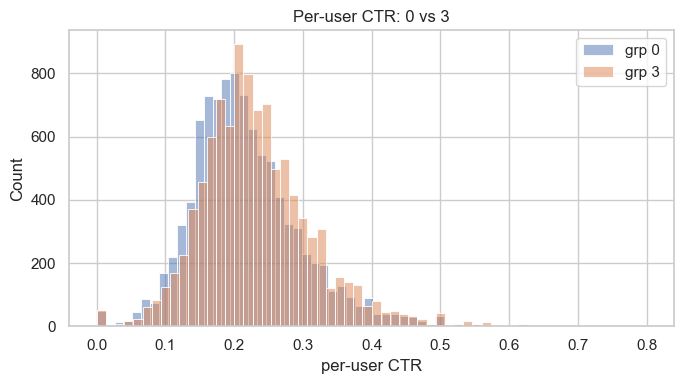

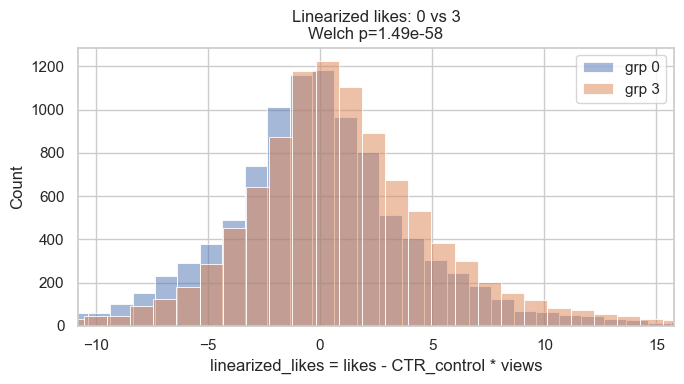

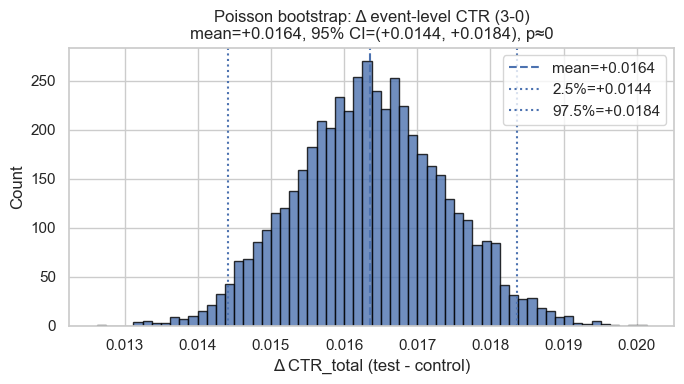

=== Control=1 vs Test=2 ===
Users: ctrl=10020, test=9877
Event-level CTR: ctrl=0.209604, test=0.200251, lift=-0.009354
Welch t-test on linearized_likes: p=2.98e-09
Welch t-test on per-user CTR    : p=0.685


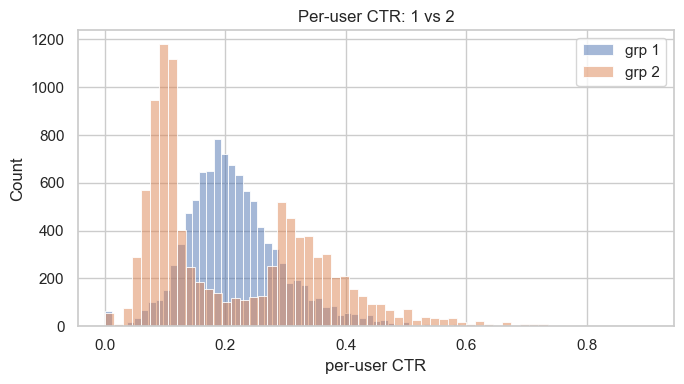

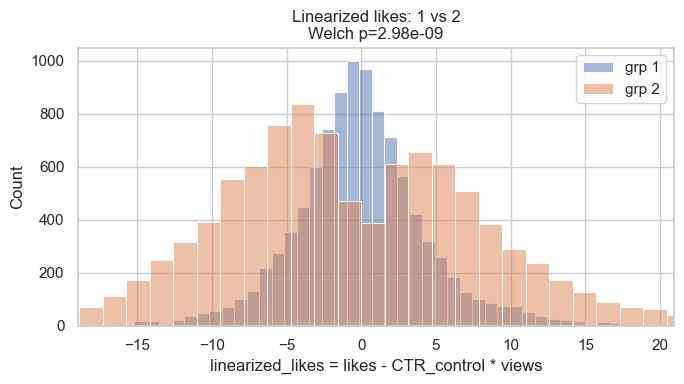

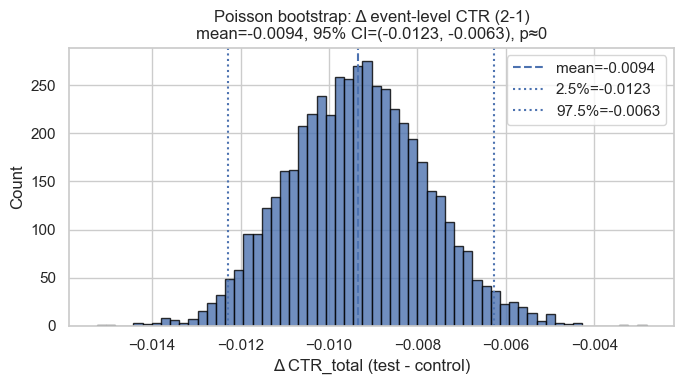

In [47]:

sns.set(style="whitegrid")

def plot_pair(df, control, test, R=5000):
    c = df[df.exp_group==control].copy()
    t = df[df.exp_group==test].copy()

    # --- базовые штуки
    ctr_ctrl = c['likes'].sum() / c['views'].sum()
    ctr_c    = c['likes'].sum() / c['views'].sum()
    ctr_t    = t['likes'].sum() / t['views'].sum()
    lift     = ctr_t - ctr_c

    # per-user CTR (фильтр на views>0)
    c_ctr = (c[c['views']>0]['likes'] / c[c['views']>0]['views']).to_numpy()
    t_ctr = (t[t['views']>0]['likes'] / t[t['views']>0]['views']).to_numpy()

    # linearized_likes
    c['lin'] = c['likes'] - ctr_ctrl * c['views']
    t['lin'] = t['likes'] - ctr_ctrl * t['views']

    p_lin = ttest_ind(c['lin'], t['lin'], equal_var=False).pvalue
    p_ctr = ttest_ind(c_ctr, t_ctr, equal_var=False).pvalue

    print(f"=== Control={control} vs Test={test} ===")
    print(f"Users: ctrl={len(c)}, test={len(t)}")
    print(f"Event-level CTR: ctrl={ctr_c:.6f}, test={ctr_t:.6f}, lift={lift:+.6f}")
    print(f"Welch t-test on linearized_likes: p={p_lin:.3g}")
    print(f"Welch t-test on per-user CTR    : p={p_ctr:.3g}")

    # ---------- 1) per-user CTR (гистограммы) ----------
    plt.figure(figsize=(7,4))
    sns.histplot(c_ctr, bins=60, stat='count', alpha=0.5, label=f'grp {control}')
    sns.histplot(t_ctr, bins=60, stat='count', alpha=0.5, label=f'grp {test}')
    plt.xlabel('per-user CTR'); plt.ylabel('Count')
    plt.title(f'Per-user CTR: {control} vs {test}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 2) linearized_likes (гистограммы) ----------
    # лимиты по 1..99 перцентилям, чтобы хвосты не «съедали» масштаб
    l = np.concatenate([c['lin'].to_numpy(), t['lin'].to_numpy()])
    lo, hi = np.percentile(l, [1, 99])

    plt.figure(figsize=(7,4))
    sns.histplot(c['lin'], bins=60, alpha=0.5, label=f'grp {control}')
    sns.histplot(t['lin'], bins=60, alpha=0.5, label=f'grp {test}')
    plt.xlim(lo, hi)
    plt.xlabel('linearized_likes = likes - CTR_control * views')
    plt.ylabel('Count')
    plt.title(f'Linearized likes: {control} vs {test}\nWelch p={p_lin:.2e}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 3) Poisson bootstrap diff of event-level CTR ----------
    rng = np.random.default_rng(0)
    def pois_ctr(d):
        w = rng.poisson(1, size=len(d))
        # защищаемся от нулевой суммы (на всякий случай)
        v = (w @ d['views'])
        return (w @ d['likes']) / v if v>0 else np.nan

    vals_c = np.array([pois_ctr(c) for _ in range(R)])
    vals_t = np.array([pois_ctr(t) for _ in range(R)])
    diff   = vals_t - vals_c
    diff   = diff[~np.isnan(diff)]

    # 95% ДИ и «эмпирический» двусторонний p
    lo_ci, hi_ci = np.percentile(diff, [2.5, 97.5])
    p_boot = 2*min((diff>=0).mean(), (diff<=0).mean())

    plt.figure(figsize=(7,4))
    plt.hist(diff, bins=60, edgecolor='black', alpha=0.8)
    plt.axvline(diff.mean(), linestyle='--', label=f"mean={diff.mean():+.4f}")
    plt.axvline(lo_ci, linestyle=':', label=f"2.5%={lo_ci:+.4f}")
    plt.axvline(hi_ci, linestyle=':', label=f"97.5%={hi_ci:+.4f}")
    plt.xlabel('Δ CTR_total (test - control)')
    plt.ylabel('Count')
    plt.title(f'Poisson bootstrap: Δ event-level CTR ({test}-{control})\n'
              f'mean={diff.mean():+.4f}, 95% CI=({lo_ci:+.4f}, {hi_ci:+.4f}), p≈{p_boot:.3g}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Запуски для обеих пар:
plot_pair(df, control=0, test=3)
plot_pair(df, control=1, test=2)